In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.spatial import cKDTree as KDTree
from tqdm.notebook import tqdm

In [4]:
prod = '/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003'

In [5]:
ref = Table.read(os.path.join(prod, 'ProductionInputEcdmHandler/star_reference_sample_dir.dir/phot.fits'), hdu=1)
len(ref)

500000

In [6]:
target = Table.read(os.path.join(prod, 'GalaxyFilteringTask/star_catalog.fits'))
len(target)

1691

In [7]:
truth = Table.read(os.path.join(prod, 'NnpzStarSed/output_file.fits'))

In [8]:
config = dict()
exec(open('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/data/nnpz_star_sed_07Jun2021-094516.conf').read(), config)

In [9]:
# Missing bands!
ref_filters = config['reference_sample_phot_filters']
target_filters = config['target_catalog_filters']

In [10]:
ref_selected = []
target_selected = []
for rname, (tname, terr) in zip(ref_filters, target_filters):
    if np.isnan(target[tname]).sum() < 1:
        ref_selected.append(rname)
        target_selected.append((tname, terr))
print(len(ref_selected), ref_selected)

9 ['euclid/VIS', 'euclid/Y', 'euclid/J', 'euclid/H', 'subaru/z', 'megacam/u', 'megacam/r', 'jpcam/g', 'panstarrs/i']


# Normalize the reference sample

In [26]:
ref_photo = np.zeros((len(ref), len(ref_selected)))
for i, fname in enumerate(ref_selected):
    ref_photo[:, i] = ref[fname]

In [27]:
ref_l2norm = ref_photo / np.sqrt(np.sum(ref_photo**2, axis=1, keepdims=True))

# KDTree

In [28]:
kdtree = KDTree(ref_l2norm)

# Load and normalize the target

In [29]:
target_photo = np.zeros((len(target), len(target_selected)))
target_err = np.zeros((len(target), len(target_selected)))
for i, (fname, ferr) in enumerate(target_selected):
    target_photo[:, i] = target[fname]
    target_err[:, i] = target[ferr]

In [30]:
target_l2norm = np.sqrt(np.sum(target_photo**2, axis=1, keepdims=True))
target_normed = target_photo / target_l2norm
err_normed = target_err / target_l2norm

In [31]:
target_mask = np.isnan(target_photo).sum(axis=1) == 0
target_mask = target_mask & (truth['FLAGS_1'] == 0)
target_mask.sum() / len(target)

0.7001774098166765

In [32]:
masked_norm = target_normed[target_mask]
masked_err = err_normed[target_mask]
masked_truth = truth[target_mask]

In [33]:
(target[target_mask]['OBJECT_ID'] == masked_truth['OBJECT_ID']).all()

True

In [34]:
target_radius = masked_err.max(axis=1) * 2.576

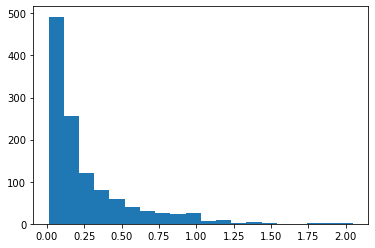

In [35]:
plt.figure()
plt.hist(target_radius, bins=20)
plt.show()

# How many match?

In [36]:
def get_matches(ref_idx):
    matches = np.zeros(len(masked_truth))
    best_idx = np.flip(masked_truth['NEIGHBOR_WEIGHTS'].argsort(axis=1), axis=1)

    for i in range(len(masked_truth)):
        ref_ids = ref['ID'][ref_idx[i]]
        best_ids = masked_truth['NEIGHBOR_IDS'][i][best_idx[i]]
        match = np.in1d(best_ids, ref_ids)
        if match.any():
            matches[i] = match.argmax() + 1
        else:
            matches[i] = -1
    return matches

In [37]:
ref_idx = kdtree.query_ball_point(masked_norm, r=target_radius)

In [38]:
cnt = list(map(len, ref_idx))

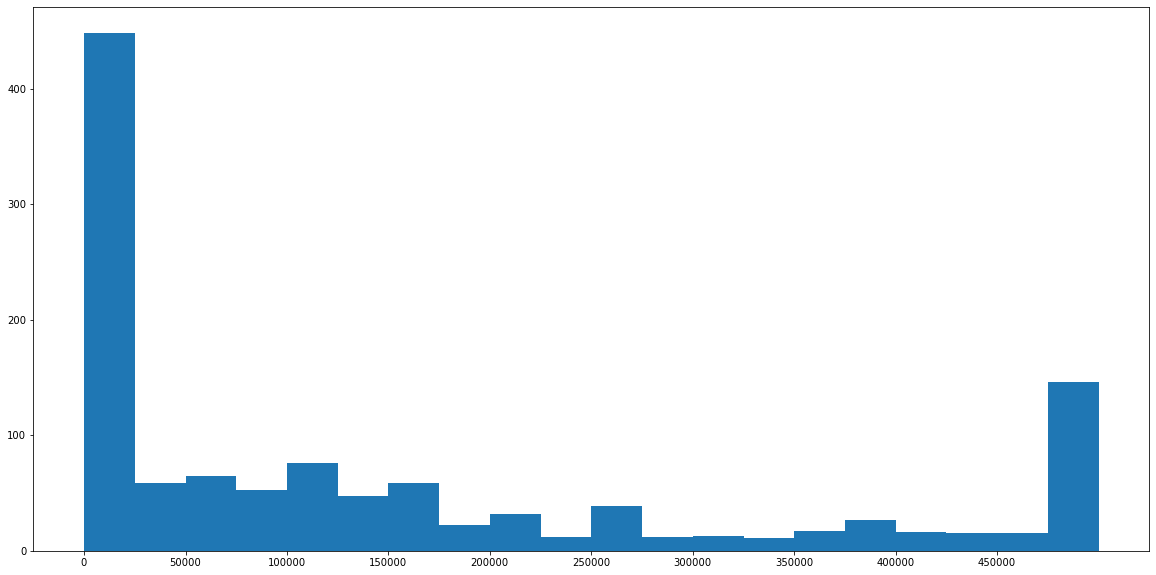

In [39]:
plt.figure(figsize=(20, 10))
plt.hist(cnt, bins=20)
plt.xticks(np.arange(0, 500000, step=50000))
plt.show()

In [40]:
np.mean(cnt)

153062.5650337838

In [41]:
best_idx = np.flip(masked_truth['NEIGHBOR_WEIGHTS'].argsort(axis=1), axis=1)

In [42]:
matches = get_matches(ref_idx)

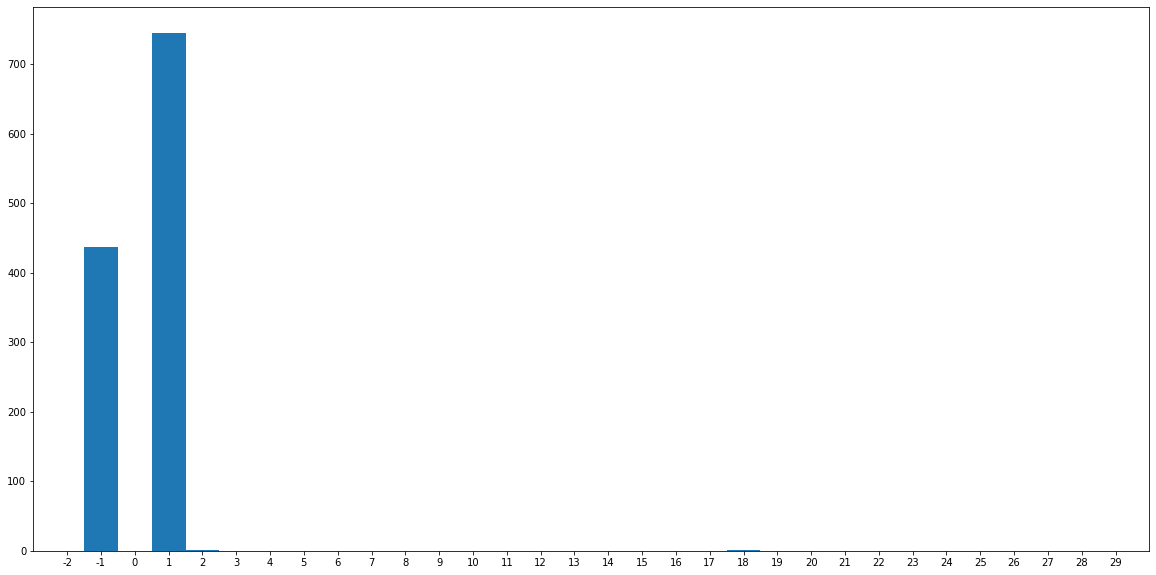

In [43]:
plt.figure(figsize=(20, 10))
plt.hist(matches, bins=np.arange(-1, 30))
plt.xticks(np.arange(-2, 30)+0.5, labels=[str(t) for t in np.arange(-2, 30)])
plt.show()